In [2]:
import qiskit

In [3]:
import mitiq

In [4]:
import numpy as np
import pandas as pd
from scipy.sparse import csc_matrix, diags
from scipy.sparse.linalg import eigs, expm_multiply
from scipy.linalg import expm
import matplotlib.pyplot as plt
import os

In [5]:
def FlipFlop(n, i, j):
    v = list(format(n, '0{}b'.format(L)))
    if (v[i] != '0' and v[j] != '1'):
        v[i] = '0'
        v[j] = '1'
        return int(''.join(v), 2)
    else:
        return -1
        
def Raise(n, i):
    v = list(format(n, '0{}b'.format(L)))
    # checking mod here, unsure why since accesses aren't modded
    if (v[i] != '1'):
        v[i] = '1'
        return int(''.join(v), 2)
    else:
        return -1

In [6]:
L = 3

In [7]:


Sz = []
for i in range(L):
    sprs = csc_matrix((2**L, 2**L), dtype=np.int8)
    for j in range(2**L):
        sprs[j, j] = 1-2*int(format(j, '0{}b'.format(L))[i])
    Sz.append(sprs)
SzTot = sum(Sz)

Sp = []
for i in range(L):
    sprs = csc_matrix((2**L, 2**L), dtype=np.int8)
    for j in range(2**L):
        h = Raise(j, i)
        if (h != -1):
            sprs[h, j] = 1
    Sp.append(sprs)

Heis = []
for i in range(L):
    _ = []
    for k in range(L):
        sprs = csc_matrix((2**L, 2**L), dtype=np.int8)
        for j in range(2**L):
            h = FlipFlop(j, i, k)
            v = lambda i: 1-2*int(format(j, '0{}b'.format(L))[i])
            if (h != -1):
                sprs[j, h] = 2
                sprs[h, j] = 2
            sprs[j, j] = v(i) * v(k)
        _.append(sprs)    
    Heis.append(_)

Sm = [Sp[i].T for i in range(L)]
Sx = [Sp[i]+Sm[i] for i in range(L)]
Sy = [-1j*Sz[i] @ Sx[i] for i in range(L)]
SxTot = sum(Sx)
SyTot = sum(Sy)

H = sum([Heis[i][(i+1)%L] for i in range(L-1)]) / 4


/usr/local/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [99]:
tf = 4
dt = tf / 300
Nt = int(tf / dt)
c = ['1','1','0'] 
UnitVector = lambda c: np.eye(2**L)[c]
init = UnitVector(int(''.join(c), 2))

In [100]:
ntrot = 2
dtrot = 0.2
_tf = 4
shots = 2**13
_shots = 8192
op = Sz[0]

ts = [i*ntrot*dtrot for i in range(int(np.ceil(tf / (ntrot * dtrot)))+1)]

In [101]:
ts

[0.0,
 0.4,
 0.8,
 1.2000000000000002,
 1.6,
 2.0,
 2.4000000000000004,
 2.8000000000000003,
 3.2,
 3.6,
 4.0]

In [102]:
revos_ = [expm(-1j * H * t) @ init for t in ts]

In [103]:
def TrotterEvolve(dt, nt, init):
    if (L % 2 == 0):
        UOdd = expm(-1j * dt * sum([Heis[i][(i+1)%L] for i in range(0, L-1, 2)]) / 4) # 0 indexing, this is actually even indices
        UEven = expm(-1j * dt * sum([Heis[i][(i+1)%L] for i in range(1, L-1, 2)]) / 4) # range(1, L, 2) for periodic bdy conditions
        UTrotter = UOdd @ UEven
        # UZ = expm(-1j * dt * sum([diags(Heis[i][(i+2)%L].diagonal()) for i in range(L)]) / 2)
        # UTrotter = UEven @ UOdd @ UZ
    else:
        UOdd = expm(-1j * dt * sum([Heis[i][(i+1)%L] for i in range(0, L-1, 2)]) / 4)
        UEven = expm(-1j * dt * sum([Heis[i][(i+1)%L] for i in range(1, L, 2)]) / 4)
        # UBdy = expm(-1j * dt * Heis[L-1][0] / 4)
        UTrotter = UOdd @ UEven # UBdy @ UOdd @ UEven
    psi_trot = init
    for i in range(nt):
        psi_trot = UTrotter @ psi_trot
    return psi_trot

In [108]:
VTDStepList = pd.read_csv(f'results_3/VTD_results_{_tf}_{L}_{ntrot}_{dtrot}_{_shots}.csv', index_col=0)
VTDStepList = VTDStepList.applymap(lambda x: complex(x))

In [109]:
VTDStepList

0         1         2                   3  \
0.0  0.000000e+00+0.000000e+00j  0.0+0.0j  0.0+0.0j  0.000000+0.000000j   
0.4  3.071373e-17-3.490879e-17j  0.0+0.0j  0.0+0.0j -0.027126+0.029170j   
0.8  1.441495e-17+1.382735e-17j -0.0+0.0j  0.0+0.0j -0.054158+0.038132j   
1.2 -6.877463e-17+3.319026e-17j  0.0+0.0j  0.0+0.0j -0.145230-0.073520j   

            4                   5                   6         7  
0.0  0.0+0.0j  0.000000+0.000000j  1.000000+0.000000j  0.0+0.0j  
0.4 -0.0+0.0j  0.024773-0.213043j  0.974638-0.049927j -0.0+0.0j  
0.8 -0.0+0.0j -0.144767-0.394448j  0.781464-0.456487j -0.0+0.0j  
1.2 -0.0+0.0j  0.241379-0.485504j  0.812213+0.140840j -0.0+0.0j

In [104]:
TrotterFixStepList = [init]
#ts = [i*ntrot*dtrot for i in range(int(np.ceil(tf / (ntrot * dtrot)))+1)]
for i in range(int(np.ceil(tf / (ntrot * dtrot)))):
    TrotterFixStepList.append(TrotterEvolve(dtrot, ntrot, TrotterFixStepList[i]))

In [105]:
TrotterFidelity = [abs(np.conj(revos_[i]) @ TrotterFixStepList[i])**2 for i in range(len(TrotterFixStepList))]

In [106]:
TrotterFidelity

[1.0,
 0.9998079350568234,
 0.9993088517174955,
 0.9986867948118545,
 0.9981381749578309,
 0.9977819075886425,
 0.9976214858428701,
 0.9975765727294374,
 0.9975596793396171,
 0.9975471115254801,
 0.9975984507989004]

In [110]:
VTDFidelity = [abs(np.conj(revos_[i]) @ np.array(VTDStepList.iloc[i]))**2 for i in range(len(VTDStepList))]

In [111]:
VTDFidelity

[1.0, 0.9985767346066251, 0.9972219056299387, 0.9987937957291004]

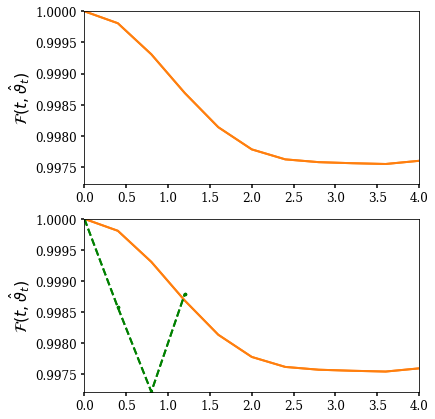

In [117]:
fig, ax = plt.subplots(2, 1, figsize=(6,7), sharey=True)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman'] + plt.rcParams['font.serif']

for i in range(2):
    ax[i].tick_params(axis='x', labelsize=12)
    ax[i].tick_params(axis='y', labelsize=12)
    ax[i].xaxis.set_tick_params(width=1.5)
    ax[i].yaxis.set_tick_params(width=1.5)
    ax[i].margins(x=0.05, y=0)
    ax[i].set_xlim(0,tf)
    #ax[i].set_ylim(0,1)
    ax[i].set_ylabel(r'$\mathcal{F}(t,  \hat{\vartheta}_t)$', fontsize=16)
    ax[i].axvspan(9, 31, facecolor='#9cce9c', alpha=0.2)
    
    ax[0].plot(ts, TrotterFidelity, label="SV Trotter w/ fixed $\Delta t$", linewidth=2, zorder=0, c='#ff7f0e')
    ax[1].plot(ts, TrotterFidelity, label="SV Trotter w/ fixed $\Delta t$", linewidth=2, zorder=0, c='#ff7f0e')
    ax[1].plot(VTDStepList.index, VTDFidelity, linestyle="--", marker='.', markersize=5, c='g', linewidth=2, label="IBM QPUs VTC")


In [26]:
plt.show()